In [9]:
import torch , torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2

import matplotlib.pyplot as plt
from torchvision import transforms
from google.colab.patches import cv2_imshow

In [10]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os

In [11]:
#import dataset
dataset , info = tfds.load('cats_vs_dogs',with_info=True,as_supervised=True)

In [ ]:
class_names = info.features['label'].names

image_list = []
label_list = []

for example in dataset['train'] :
  image , label = example
  image_list.append(image.numpy())
  label_list.append(label)
  

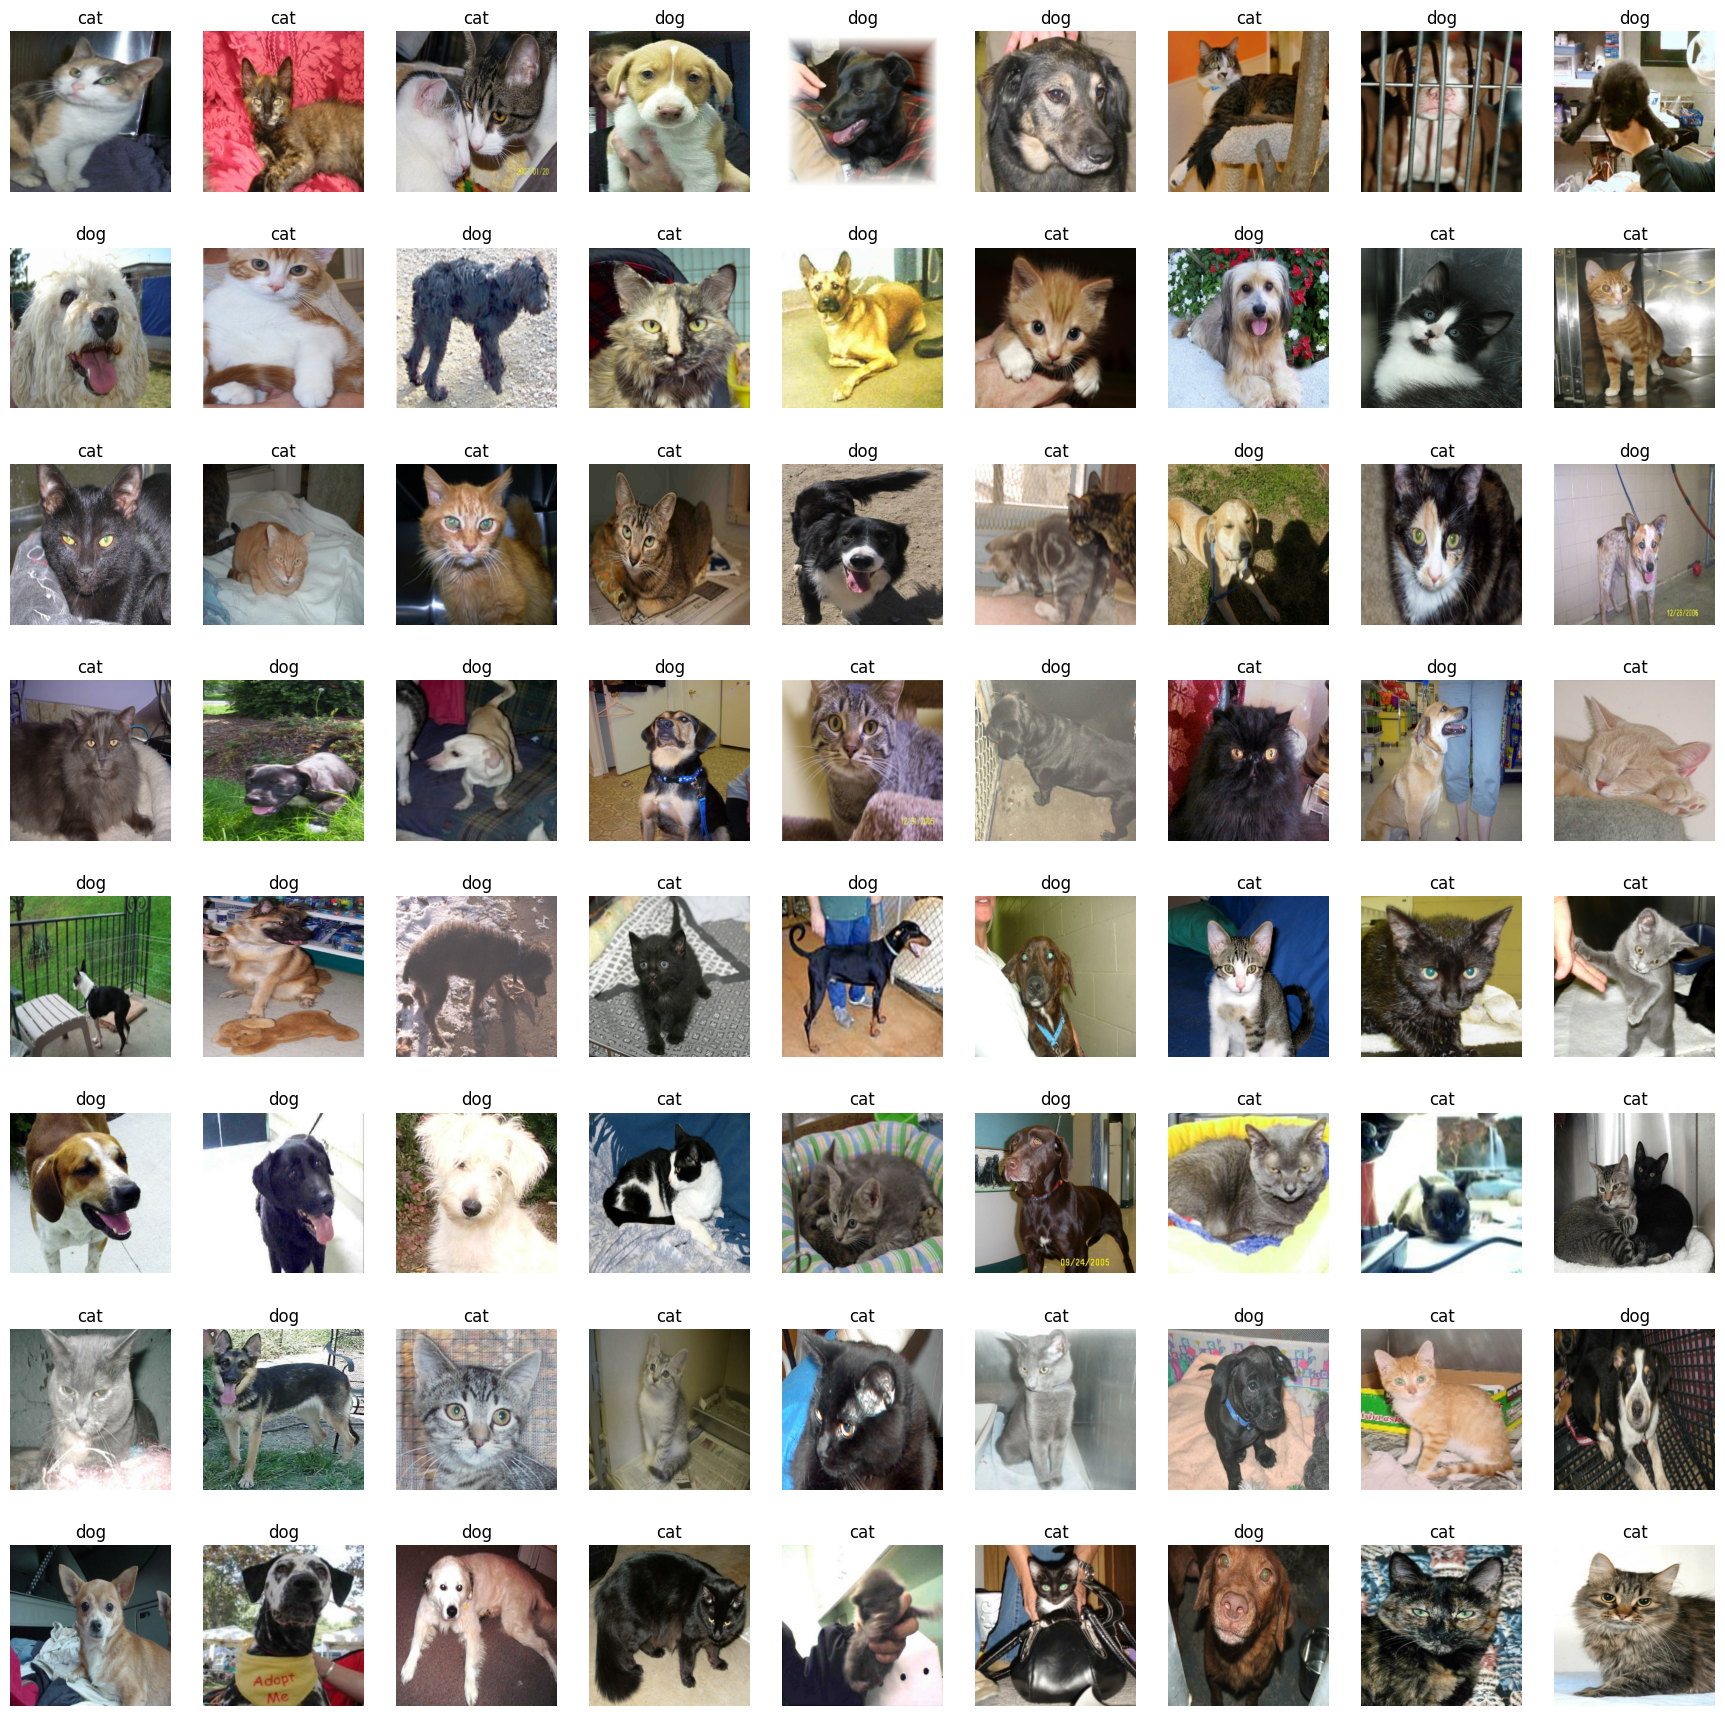

In [ ]:
#Visualizing the data
figure = plt.figure(figsize=(22,22))

image_index = 100

cols,rows = 9,8
for i in range(1,cols*rows+1):
  image_idx = i-1
  figure.add_subplot(rows,cols,i)
  plt.title(class_names[label_list[image_index + image_idx]])
  plt.axis("off")
  plt.imshow(cv2.resize(image_list[image_index + image_idx],(350,350)))
plt.show()

In [13]:
class_names = info.features['label'].names

for i , example in enumerate(dataset['train']) :
  image , label = example
  save_dir = './cats_vs_dogs/train/{}'.format(class_names[label])  
  os.makedirs(save_dir , exist_ok=True)
  #cv2_imshow(image.numpy())
  filename = save_dir + '/' + '{}_{}.jpg'.format(class_names[label],i)
  tf.keras.preprocessing.image.save_img(filename,image.numpy())

KeyboardInterrupt: ignored

In [129]:
#Preprocessing Data with Pytorch

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

dataset = ImageFolder('/content/cats_vs_dogs/train')

#print(dataset)

train_data , test_data , train_label , test_label = train_test_split(dataset.imgs , dataset.targets,test_size = 0.2 , random_state=0)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip horizontal secara acak
    transforms.RandomRotation(10),
    transforms.Resize((150,150)),
    transforms.ToTensor()
])

class ImageLoader(Dataset):
  def __init__(self,dataset, transform=None):
    self.dataset = self.checkChannel(dataset)
    self.transform = transform

  def checkChannel(self, dataset):
    datasetRGB = []
    for index in range(len(dataset)) :
      if Image.open(dataset[index][0]).getbands() == ('R' , 'G' , 'B') and dataset[index][0] != '/content/cats_vs_dogs/train/cat/cat_14604.jpg':
        datasetRGB.append(dataset[index])
    return datasetRGB

  def __getitem__(self , item):
    image = self.getResizedImage(item)
    #image = Image.open(self.dataset[item][0])
    if self.transform is not None :
      return self.transform(image),self.dataset[item][1]
    return image, self.dataset[item][1]

  def getResizedImage(self,item):
    try :
      image = Image.open(self.dataset[item][0])
      _,_,width,height = image.getbbox()
      factor = (0,0,width,width) if width > height else(0,0,height,height)
      return image.crop(factor)
    except Exception as e:
      print(self.dataset[item][0])
      print("Terjadi kesalahan saat membuka gambar:", str(e))
  
  def __len__(self):
    return len(self.dataset)

train_data_w = ImageLoader(train_data)
test_data_w = ImageLoader(test_data)

train_data = ImageLoader(train_data,transform)
test_data = ImageLoader(test_data,transform)

#Show image
#print(ImageLoader[0][1])
#ImageLoader[0][0].show()

#print(dataset.imgs)
#print(dataset.targets)
#print(dataset.classes)

In [91]:
#print(np.array(train_data_w[0][0]))
print(train_data[2][0])

#Set the batch
batchSize = 50
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=batchSize, shuffle=False)

tensor([[[0.2471, 0.2471, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
         [0.2941, 0.2902, 0.2824,  ..., 0.0000, 0.0000, 0.0000],
         [0.3843, 0.3765, 0.3686,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.6314, 0.6275, 0.6000,  ..., 0.0000, 0.0000, 0.0000],
         [0.6314, 0.6510, 0.6627,  ..., 0.0000, 0.0000, 0.0000],
         [0.6392, 0.6314, 0.6510,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.2235, 0.2275, 0.2275,  ..., 0.0000, 0.0000, 0.0000],
         [0.2784, 0.2745, 0.2667,  ..., 0.0000, 0.0000, 0.0000],
         [0.3765, 0.3686, 0.3608,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.6000, 0.5922, 0.5686,  ..., 0.0000, 0.0000, 0.0000],
         [0.6078, 0.6235, 0.6353,  ..., 0.0000, 0.0000, 0.0000],
         [0.6157, 0.6039, 0.6196,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.2314, 0.2314, 0.2353,  ..., 0.0000, 0.0000, 0.0000],
         [0.2824, 0.2784, 0.2706,  ..., 0.0000, 0.0000, 0.0000],
         [0.3804, 0.3725, 0.3647,  ..., 0.0000, 0.0000, 0.

In [ ]:
print(train_data[1][0].shape)

torch.Size([3, 250, 250])


In [42]:
# MyCNN
class Net(nn.Module):
  def __init__(self,num_classes=2):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=40 , kernel_size=3,stride=1,padding=0)
    self.conv2 = torch.nn.Conv2d(in_channels=40,out_channels=50, kernel_size=4 , stride=1, padding=0)
    self.conv3 = torch.nn.Conv2d(in_channels=50,out_channels=100, kernel_size=5 , stride=1, padding=0)
    self.fc3 = torch.nn.Linear(100*28*28,1000)
    self.fciadd = torch.nn.Linear(1000,600)
    self.dropout1 = nn.Dropout(0.5)
    self.fc4 = torch.nn.Linear(600,num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2,2)

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2,2)

    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2,2)

    x = x.view(-1,100*28*28)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fciadd(x))
    x = self.dropout1(x)
    x = self.fc4(x)
    return x

In [120]:
#Video CNN
class Net(nn.Module):
  def __init__(self,num_classes=2):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32 , kernel_size=5,stride=1,padding=0)
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64 , kernel_size=3,stride=2,padding=0)
    self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128 , kernel_size=3,stride=1,padding=0)
    self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256 , kernel_size=3,stride=1,padding=0)    
    self.fc1 = torch.nn.Linear(256*2*2,512)
    self.fc2 = torch.nn.Linear(512,256)
    self.fc3 = torch.nn.Linear(256,num_classes)
    self.dropout1 = nn.Dropout(0.2)
    self.dropout2 = nn.Dropout(0.5)
  
  def forward(self, x):
    # 1st Conv layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2,2)
    x = self.dropout1(x)
    
    # 2st Conv layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2,2)
    x = self.dropout1(x)

    # 3st Conv layer
    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2,2)
    x = self.dropout1(x)

    # 4st Conv layer
    x = self.conv4(x)
    x = F.relu(x)
    x = F.max_pool2d(x,3,3)
  
    # Flatten
    x = x.view(-1,256*2*2)
    x = self.dropout2(x)

    # 5st FC layer
    x = self.fc1(x)
    x = F.relu(x)
    
    # 6st FC layer
    x = self.fc2(x)
    x = F.relu(x)

    # 7st FC layer
    x = self.fc3(x)
    x = F.softmax(x,1)
    return x


In [121]:
device = 'cuda'
model = Net()
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0003)

#Epoch History
training_loss_history = []
training_corrects_history = []

val_loss_history = []
val_corrects_history = []

#Print Parameter Count
total_param = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Lapisan {name} memiliki jumlah parameter: {param.numel()}")
        total_param += param.numel()
print(f'Total Parameter : {total_param}')

Lapisan conv1.weight memiliki jumlah parameter: 2400
Lapisan conv1.bias memiliki jumlah parameter: 32
Lapisan conv2.weight memiliki jumlah parameter: 18432
Lapisan conv2.bias memiliki jumlah parameter: 64
Lapisan conv3.weight memiliki jumlah parameter: 73728
Lapisan conv3.bias memiliki jumlah parameter: 128
Lapisan conv4.weight memiliki jumlah parameter: 294912
Lapisan conv4.bias memiliki jumlah parameter: 256
Lapisan fc1.weight memiliki jumlah parameter: 524288
Lapisan fc1.bias memiliki jumlah parameter: 512
Lapisan fc2.weight memiliki jumlah parameter: 131072
Lapisan fc2.bias memiliki jumlah parameter: 256
Lapisan fc3.weight memiliki jumlah parameter: 512
Lapisan fc3.bias memiliki jumlah parameter: 2
Total Parameter : 1046594


In [131]:
for e in range(1) :
  # Drop out Aktif
  model.train()
  running_loss = 0.0
  running_corrects = 0.0

  val_running_loss = 0.0
  val_running_corrects = 0.0

  CounterTraining = 0
  CounterVal = 0
  for inputs,labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,preds = torch.max(outputs,1)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    #print(torch.sum(preds == labels.data))
    CounterTraining += 1

  else:
    with torch.no_grad():
      #Drop Out Mati
      model.eval()
      for val_inputs,val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        #foward Propagation
        val_outputs = model(val_inputs)
        #calculate loss
        val_loss = (criterion(val_outputs,val_labels))
        #predictions
        _,val_preds = torch.max(val_outputs,1)
        #update val running loss
        val_running_loss += val_loss.item()
        #update val accuracy
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        CounterVal += 1
  #Calculate Training Loss
  epoch_loss = running_loss/len(train_loader.dataset)
  training_loss_history.append(epoch_loss)

  # Calculate Training Accuracy
  epoch_acc = running_corrects.float()/len(train_loader.dataset)
  training_corrects_history.append(epoch_acc)


  #Calculate Validation Loss
  val_epoch_loss = val_running_loss/len(val_loader.dataset)
  val_loss_history.append(val_epoch_loss)

  #Calculate Validation Accuracy
  val_epoch_acc = val_running_corrects.float()/len(val_loader.dataset)
  val_corrects_history.append(val_epoch_acc)
  # Priniting the epoch, loss and accuracy
  print('Epoch :', (e+1))
  print('Training loss: {:.4f}, Training accuracy {:.4f} '.format(epoch_loss, epoch_acc.item()) , 'Jumlah Benar : ' , epoch_acc.item()*(CounterTraining*batchSize) , '/' ,(CounterTraining*batchSize))
  print('Validation loss: {:.4f}, Validation accuracy {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()) , 'Jumlah Benar : ', val_epoch_acc.item()*(CounterVal*batchSize) , '/' ,(CounterVal*batchSize))

Epoch : 1
Training loss: 0.0080, Training accuracy 0.9112  Jumlah Benar :  16993.269473314285 / 18650
Validation loss: 0.0085, Validation accuracy 0.8876  Jumlah Benar :  4171.717220544815 / 4700


In [127]:
path = "/content/drive/MyDrive/ComputerVision/Pytorch/catsvsdogs88.pth"
torch.save(model.state_dict(), path)

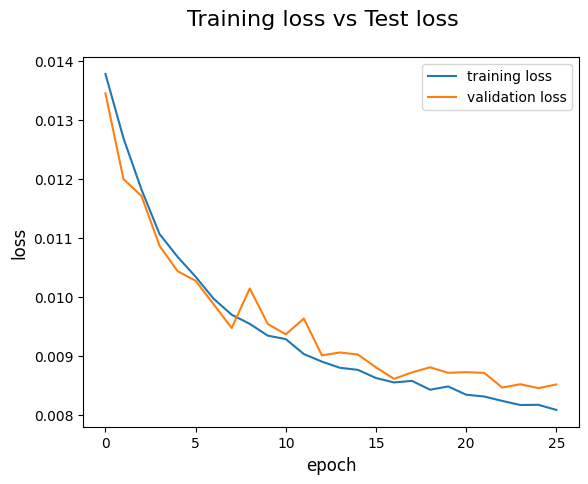

In [124]:
#plot the training and validation loss
plt.plot(training_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.suptitle('Training loss vs Test loss', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend()

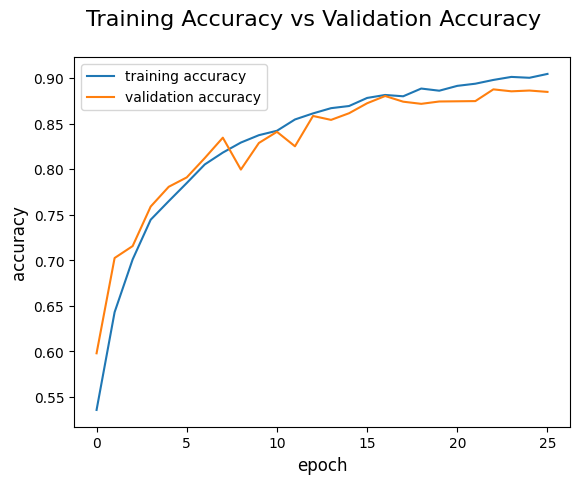

In [125]:
#plot the training and validation accuracy

#if training with cuda
training_corrects_history = [i.item() for i in training_corrects_history]
val_corrects_history = [i.item() for i in val_corrects_history]

plt.plot(training_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.suptitle('Training Accuracy vs Validation Accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend()